In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import re

from datetime import datetime
import numpy as np

import warnings
warnings.filterwarnings('ignore')

# 지수 표기법을 10진수로 변경
pd.set_option('display.float_format', '{:.2f}'.format)

import platform

system = platform.system()

if system == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'
    
else:
    !apt-get -y install fonts-nanum
    !fc-cache -fv
    !rm ~/.cache/matplotlib -rf

    plt.rcParams['font.family'] = 'NanumBarunGothic'

# minus 기호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

# 데이터 확인

In [2]:
df = pd.read_csv("./data/wowple_db_reviews.csv")
df['year_month'] = pd.to_datetime(df['date'], format='%Y년 %m월 %d일').dt.strftime('%y-%m')
df = df.drop(columns='_id')
df = df.drop_duplicates()

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   writer      64 non-null     object
 1   content     64 non-null     object
 2   suefull     64 non-null     int64 
 3   date        64 non-null     object
 4   rating      64 non-null     int64 
 5   year_month  64 non-null     object
dtypes: int64(2), object(4)
memory usage: 3.1+ KB


In [4]:
df

,writer,content,suefull,date,rating,year_month
0,Dk 7446,일단 앱을 깔았는데 관리자에게 문의를 하라면서 무한로딩만 계속됩니다. 패드에서는 잘...,3,2022년 11월 4일,5,22-11
1,ᄋᄋ,이건 좀 심한거 아닌가요? 로딩 한참 걸리더니 로그아웃 처리되고 로그인 하니까 아예...,0,2024년 12월 7일,1,24-12
2,K C,독서실 이용을 하려서 알아보던중 주변 지인의 추천으로 앱 깔아서 사용해 봤는데 편리하네요,0,2024년 9월 25일,5,24-09
3,been,회원가입을 해야 뭘 쓰든 말든 하는데 정보 다 입력하고 남자 여자 선택하는 창에서 ...,2,2022년 4월 2일,1,22-04
4,Kim Js,와우플 업데이트후 거리순이 없어서 불편함. 그리고 초기화면에 나오는 숫자는 이용가능...,1,2024년 6월 26일,3,24-06
...,...,...,...,...,...,...
59,조미연,오류 뜨면서 관리자에게 문의하라는데 해결 부탁드려요.,0,2022년 8월 25일,1,22-08
60,헤헿,잘 이용하고 있습니다.,1,2024년 3월 20일,5,24-03
61,강강강,앱이 안돼요,0,2021년 11월 18일,1,21-11
62,Jim,유용합니다~,0,2023년 11월 5일,5,23-11


In [10]:
df_uesfull = df.query('suefull > 0')

# 시각화

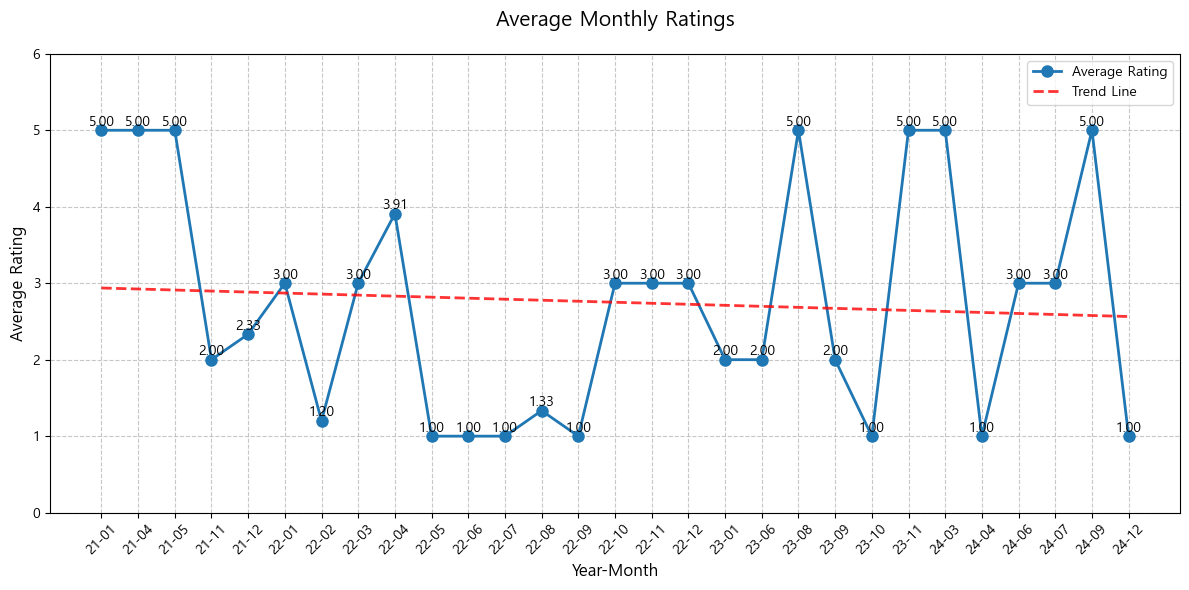

In [17]:
# 데이터 준비: year_month별 rating 평균 계산
monthly_avg = df.groupby('year_month')['rating'].mean().reset_index()

# 그래프 크기 설정
plt.figure(figsize=(12, 6))

# 메인 선 그래프
plt.plot(monthly_avg['year_month'], monthly_avg['rating'], 
         marker='o', linewidth=2, markersize=8, label='Average Rating')

# 추세선 추가
x = np.arange(len(monthly_avg))
z = np.polyfit(x, monthly_avg['rating'], 1)
p = np.poly1d(z)
plt.plot(x, p(x), '--', color='red', alpha=0.8, linewidth=2, label='Trend Line')

# 평균값 텍스트 표시
for i, value in enumerate(monthly_avg['rating']):
    plt.text(i, value + 0.02, f'{value:.2f}', 
             ha='center', va='bottom')

# 그래프 스타일링
plt.title('Average Monthly Ratings', pad=20, fontsize=15)
plt.xlabel('Year-Month', fontsize=12)
plt.ylabel('Average Rating', fontsize=12)

# x축 레이블 회전
plt.xticks(rotation=45)

# y축 범위 조정 (3.5~5)
plt.ylim(0, 6)

# 그리드 추가
plt.grid(True, linestyle='--', alpha=0.7)

# 범례 추가
plt.legend()

# 여백 조정
plt.tight_layout()

# 그래프 표시
plt.show()

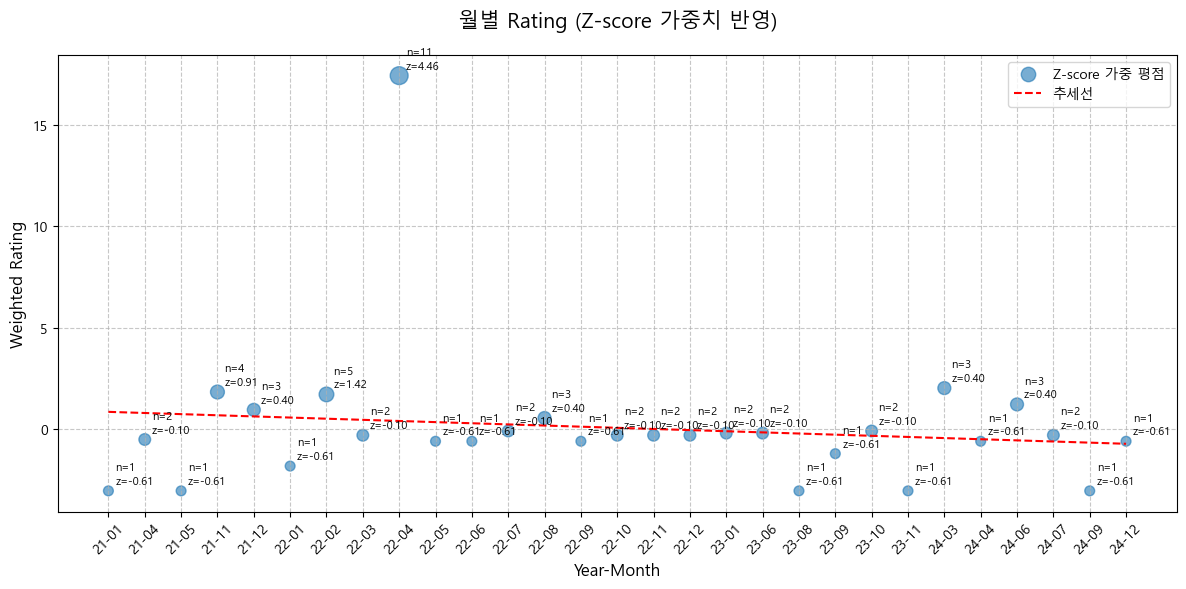


통계 정보:
전체 리뷰 수: 64
월별 Z-score 가중 Rating 범위:
최소: -3.06
최대: 17.44
평균: 0.05


In [6]:
from matplotlib import font_manager as fm

# 월별 평균 rating과 리뷰 수 계산
monthly_stats = df.groupby('year_month').agg({
    'rating': ['mean', 'count']
}).reset_index()

# 컬럼 이름 재설정
monthly_stats.columns = ['year_month', 'rating', 'review_count']

# z-score 계산
review_mean = monthly_stats['review_count'].mean()
review_std = monthly_stats['review_count'].std()
monthly_stats['z_score'] = (monthly_stats['review_count'] - review_mean) / review_std
monthly_stats['weighted_rating'] = monthly_stats['rating'] * monthly_stats['z_score']

# 폰트 설정
font_path = r'C:\Windows\Fonts\malgun.ttf'
font_prop = fm.FontProperties(fname=font_path)
fm.fontManager.addfont(font_path)
plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['axes.unicode_minus'] = False

# 그래프 생성
plt.figure(figsize=(12, 6))

# 산점도 그리기 (크기는 리뷰 수에 비례)
sizes = np.sqrt(monthly_stats['review_count']) * 50
scatter = plt.scatter(monthly_stats['year_month'], monthly_stats['weighted_rating'], 
                     s=sizes, alpha=0.6, label='Z-score 가중 평점')

# 추세선 추가
x = np.arange(len(monthly_stats))
z = np.polyfit(x, monthly_stats['weighted_rating'], 1)
p = np.poly1d(z)
plt.plot(monthly_stats['year_month'], p(x), "r--", label='추세선')

# 그래프 스타일링
plt.title('월별 Rating (Z-score 가중치 반영)', pad=20, fontsize=15)
plt.xlabel('Year-Month', fontsize=12)
plt.ylabel('Weighted Rating', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)

# 리뷰 수와 z-score 표시
for i, row in monthly_stats.iterrows():
    plt.annotate(f'n={int(row["review_count"])}\nz={row["z_score"]:.2f}', 
                (row['year_month'], row['weighted_rating']),
                xytext=(5, 5), textcoords='offset points',
                fontsize=8)

plt.legend()
plt.tight_layout()
plt.show()

# 통계 정보 출력
print("\n통계 정보:")
print(f"전체 리뷰 수: {monthly_stats['review_count'].sum()}")
print("월별 Z-score 가중 Rating 범위:")
print(f"최소: {monthly_stats['weighted_rating'].min():.2f}")
print(f"최대: {monthly_stats['weighted_rating'].max():.2f}")
print(f"평균: {monthly_stats['weighted_rating'].mean():.2f}")


통계 정보 (23-01 ~ 24-12):
전체 리뷰 수: 20
평균 평점: 2.95

별점 별 비율:
1점: 40.0% (8개)
2점: 5.0% (1개)
3점: 15.0% (3개)
5점: 40.0% (8개)


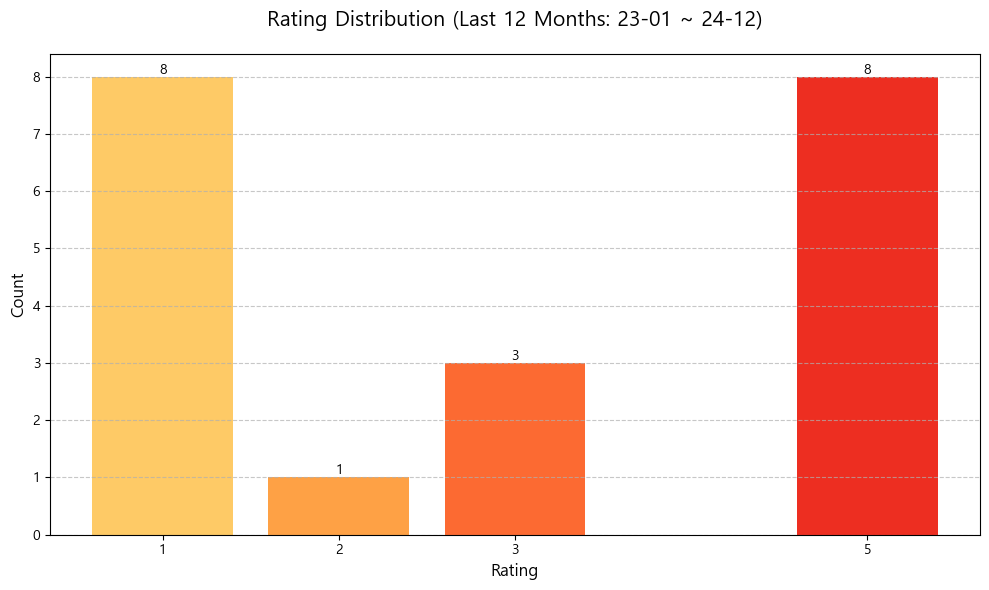

In [7]:
# 최근 12개월치 데이터 필터링
unique_months = sorted(df['year_month'].unique())[-12:]
df_year = df[df['year_month'].isin(unique_months)]

# 별점별 카운트
rating_counts = df_year['rating'].value_counts().sort_index()

# 그래프 크기 설정
plt.figure(figsize=(10, 6))

# 막대 그래프 생성
bars = plt.bar(rating_counts.index, rating_counts.values, 
               color=plt.cm.YlOrRd(np.linspace(0.3, 0.7, len(rating_counts))))

# 각 막대 위에 값 표시
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height):,}',
             ha='center', va='bottom')

# 그래프 스타일링
plt.title(f'Rating Distribution (Last 12 Months: {unique_months[0]} ~ {unique_months[-1]})', 
         pad=20, fontsize=15)
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Count', fontsize=12)

# x축 설정
plt.xticks(rating_counts.index)

# 그리드 추가
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# 여백 조정
plt.tight_layout()

# 통계 정보 계산 및 출력
total_reviews = rating_counts.values.sum()
average_rating = np.sum(rating_counts.index * rating_counts.values) / total_reviews

print(f"\n통계 정보 ({unique_months[0]} ~ {unique_months[-1]}):")
print(f"전체 리뷰 수: {total_reviews:,}")
print(f"평균 평점: {average_rating:.2f}")
print("\n별점 별 비율:")
for rating in rating_counts.index:
    percentage = (rating_counts[rating] / total_reviews) * 100
    print(f"{rating}점: {percentage:.1f}% ({rating_counts[rating]:,}개)")

plt.show()

### 최근 1년간 별점별 리뷰 분석 ###


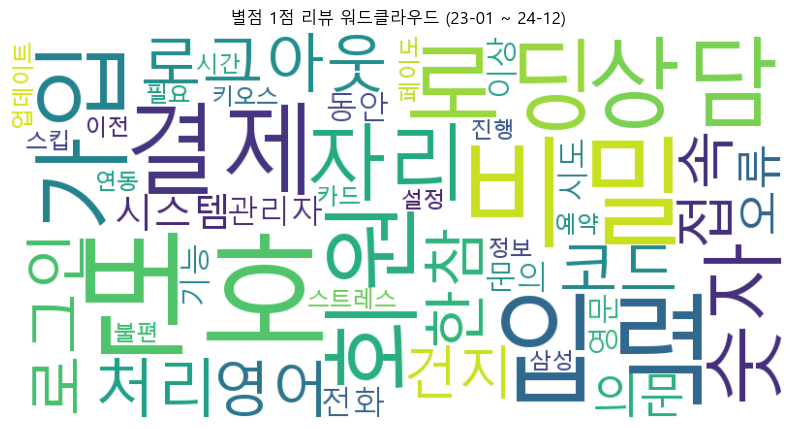


별점 1점의 상위 20개 단어:
번호: 4회
비밀: 3회
입력: 3회
로딩: 2회
결제: 2회
상담: 2회
회원: 2회
가입: 2회
자리: 2회
숫자: 2회
한참: 1회
로그아웃: 1회
처리: 1회
로그인: 1회
영어: 1회
코드: 1회
접속: 1회
건지: 1회
의문: 1회
오류: 1회
총 리뷰 수: 8개
--------------------------------------------------


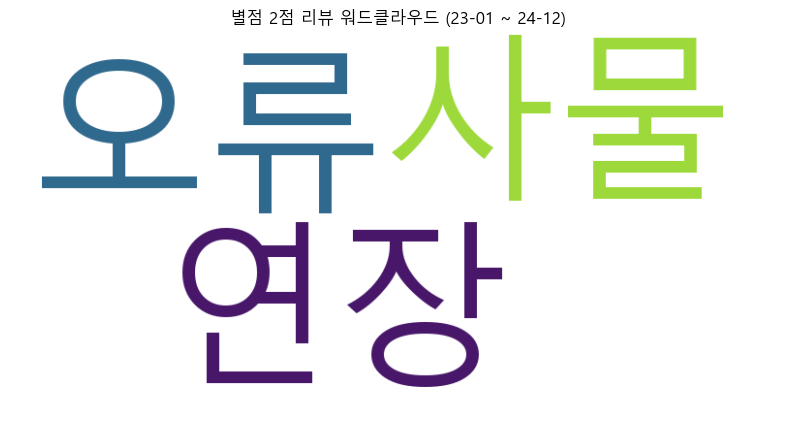


별점 2점의 상위 20개 단어:
사물: 1회
연장: 1회
오류: 1회
총 리뷰 수: 1개
--------------------------------------------------


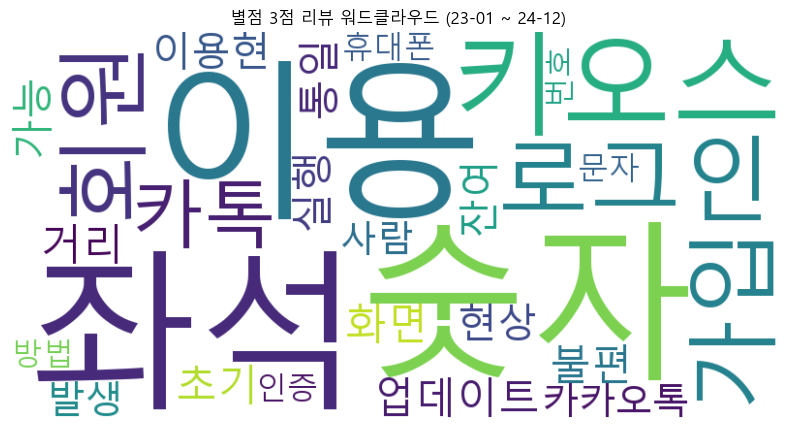


별점 3점의 상위 20개 단어:
숫자: 2회
이용: 2회
좌석: 2회
키오스: 2회
로그인: 2회
회원: 2회
가입: 2회
카톡: 2회
업데이트: 1회
거리: 1회
불편: 1회
초기: 1회
화면: 1회
가능: 1회
실행: 1회
통일: 1회
이용현: 1회
잔여: 1회
현상: 1회
발생: 1회
총 리뷰 수: 3개
--------------------------------------------------


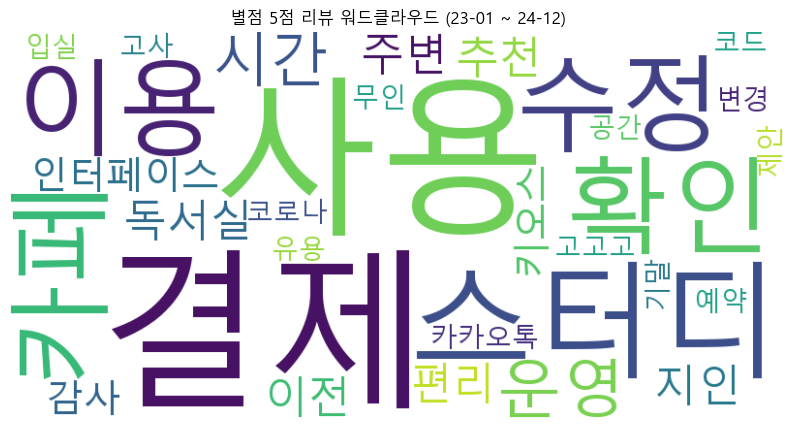


별점 5점의 상위 20개 단어:
사용: 3회
결제: 3회
스터디: 3회
이용: 2회
수정: 2회
카페: 2회
확인: 2회
운영: 2회
시간: 2회
독서실: 1회
주변: 1회
지인: 1회
추천: 1회
편리: 1회
이전: 1회
인터페이스: 1회
감사: 1회
키오스: 1회
카카오톡: 1회
코드: 1회
총 리뷰 수: 8개
--------------------------------------------------


In [8]:
from eunjeon import Mecab
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd

# MeCab 형태소 분석기 초기화
mecab = Mecab()

# 불용어 정의
stopwords = {'너무', '정말', '진짜', '아주', '매우', '좋다', '좋은', '좋아요', '좋고', 
             '같다', '같은', '같아요', '이다', '이고', '입니다', '있다', '하다', '하고',
             '그리고', '입니다', '있어요', '없다', '없어요', '했다', '했어요', '네요',
             '음', '는', '을', '를', '이', '가', '의', '과', '로', '으로'}

def get_nouns(text):
    """텍스트에서 명사 추출"""
    morphs = mecab.pos(str(text))
    nouns = []
    for word, tag in morphs:
        if tag.startswith('NN'):  
            if len(word) > 1 and word not in stopwords:
                nouns.append(word)
    return nouns

def create_wordcloud_by_rating(df):
    """별점별 워드클라우드 생성"""
    # 최근 12개월치 데이터 필터링
    unique_months = sorted(df['year_month'].unique())[-12:]
    df_year = df[df['year_month'].isin(unique_months)]
    
    # 각 별점별로 워드클라우드 생성
    for rating in sorted(df_year['rating'].unique()):
        # 해당 별점의 데이터만 필터링
        rating_df = df_year[df_year['rating'] == rating]
        
        # 모든 리뷰에서 명사 추출
        all_nouns = []
        for text in rating_df['content']:
            all_nouns.extend(get_nouns(text))
        
        # 단어 빈도수 계산
        word_count = Counter(all_nouns)
        
        if word_count:  # 리뷰가 있는 경우에만
            # 워드클라우드 생성
            wc = WordCloud(
                font_path='C:/Windows/Fonts/malgun.ttf',
                width=800,
                height=400,
                background_color='white',
                max_words=100,
                colormap='viridis'
            )
            
            wc.generate_from_frequencies(word_count)
            
            # 워드클라우드 시각화
            plt.figure(figsize=(10, 8))
            plt.imshow(wc, interpolation='bilinear')
            plt.axis('off')
            plt.title(f'별점 {rating}점 리뷰 워드클라우드 ({unique_months[0]} ~ {unique_months[-1]})')
            plt.show()
            
            # 상위 20개 단어와 빈도수 출력
            print(f'\n별점 {rating}점의 상위 20개 단어:')
            for word, count in word_count.most_common(20):
                print(f'{word}: {count}회')
            print(f'총 리뷰 수: {len(rating_df)}개')
            print('-' * 50)

# 별점별 워드클라우드 생성
print("### 최근 1년간 별점별 리뷰 분석 ###")
create_wordcloud_by_rating(df)

In [19]:
df_uesfull.sort_values('year_month',ascending=False).query('rating < 3')

,writer,content,suefull,date,rating,year_month
19,래,아니 앱을 만들거면 좀 똑바로 만드세요 ㅋㅋ 회원가입하고 네자리 비밀번호 입력하래서...,1,2024년 7월 1일,1,24-07
29,Forc3r,회원가입 키오스크 비밀번호 설정에서 스킵도 안되고 어떤 숫자를 입력해도 안되네요,1,2024년 4월 10일,1,24-04
7,성ha,1.로딩 매우 길고 2.결제는 계속 오류나고 시스템 관리자에게 문의하라고 해서 3....,2,2023년 10월 4일,1,23-10
17,temp k,ㅋㅋㅋㅋㅋㅋㅋㅋㅋ 이딴 것도 어플이라고 만들었나 ㅋㅋㅋㅋ 회원가입 인증번호는 무슨 ...,1,2022년 12월 30일,1,22-12
15,Juyeong Kim,앱을 처음 설치하고 실행하자마자 관리자에게 문의달라는 오류창만 뜨고 계속 버퍼링만 ...,1,2022년 7월 4일,1,22-07
3,been,회원가입을 해야 뭘 쓰든 말든 하는데 정보 다 입력하고 남자 여자 선택하는 창에서 ...,2,2022년 4월 2일,1,22-04
31,Andrew Kang,아래 대댓글 다신거 보니까 고치셨다는데 로그인하면 계속 튕기는데요.. ㅋ,1,2022년 2월 11일,1,22-02
42,박소현,로그인 후 계속 강제종료됩니다 빨리 수정해주세요,3,2022년 2월 7일,1,22-02
44,누눙누눙,로그인 이후 재접속 안되는 오류 있다고 두 번째 리뷰 씁니다 제 리뷰 포함해서 몇몇...,8,2022년 2월 24일,1,22-02
55,김나연,어플이 안들어가져요 ㅠ 자꾸 튕김 ㅠ,1,2022년 2월 5일,2,22-02


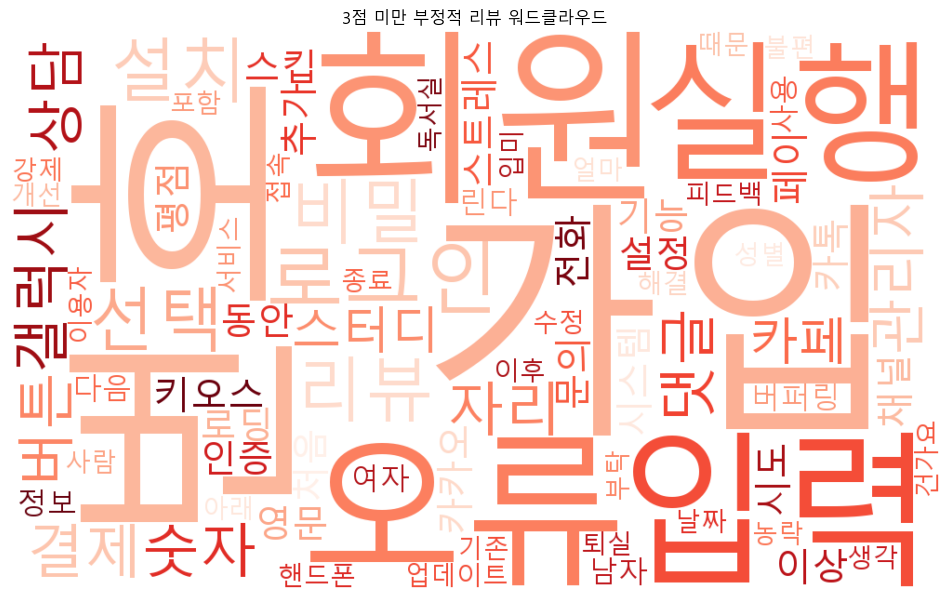


가장 많이 등장한 단어 TOP 30:
가입: 5회
번호: 5회
회원: 4회
입력: 4회
오류: 4회
실행: 4회
로그인: 4회
비밀: 3회
설치: 3회
선택: 3회
리뷰: 3회
자리: 2회
숫자: 2회
결제: 2회
관리자: 2회
상담: 2회
버튼: 2회
댓글: 2회
갤럭시: 2회
스터디: 2회
카페: 2회
영문: 1회
이상: 1회
스트레스: 1회
키오스: 1회
설정: 1회
스킵: 1회
로딩: 1회
시스템: 1회
문의: 1회

분석된 총 리뷰 수: 15개
평균 평점: 1.07
기간: 24-07 ~ 21-11


In [21]:
from eunjeon import Mecab
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

# MeCab 형태소 분석기 초기화
mecab = Mecab()

# 불용어 정의
stopwords = {'너무', '정말', '진짜', '아주', '매우', '좋다', '좋은', '좋아요', '좋고', 
             '같다', '같은', '같아요', '이다', '이고', '입니다', '있다', '하다', '하고',
             '그리고', '입니다', '있어요', '없다', '없어요', '했다', '했어요', '네요',
             '음', '는', '을', '를', '이', '가', '의', '과', '로', '으로'}

def get_nouns(text):
    """텍스트에서 명사 추출"""
    morphs = mecab.pos(str(text))
    nouns = []
    for word, tag in morphs:
        if tag.startswith('NN'):  
            if len(word) > 1 and word not in stopwords:
                nouns.append(word)
    return nouns

# 데이터 필터링
negative_reviews = df_uesfull.sort_values('year_month',ascending=False).query('rating < 3')

# 모든 리뷰에서 명사 추출
all_nouns = []
for text in negative_reviews['content']:
    all_nouns.extend(get_nouns(text))

# 단어 빈도수 계산
word_count = Counter(all_nouns)

if word_count:  # 리뷰가 있는 경우에만
    # 워드클라우드 생성
    wc = WordCloud(
        font_path='C:/Windows/Fonts/malgun.ttf',
        width=1000,
        height=600,
        background_color='white',
        max_words=100,
        colormap='Reds'  # 부정적 리뷰이므로 붉은 계열 사용
    )
    
    wc.generate_from_frequencies(word_count)
    
    # 워드클라우드 시각화
    plt.figure(figsize=(12, 8))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title('3점 미만 부정적 리뷰 워드클라우드')
    plt.show()
    
    # 상위 30개 단어와 빈도수 출력
    print(f'\n가장 많이 등장한 단어 TOP 30:')
    for word, count in word_count.most_common(30):
        print(f'{word}: {count}회')
        
    print(f'\n분석된 총 리뷰 수: {len(negative_reviews)}개')
    print(f'평균 평점: {negative_reviews["rating"].mean():.2f}')
    print(f'기간: {negative_reviews["year_month"].max()} ~ {negative_reviews["year_month"].min()}')